<a href="https://colab.research.google.com/github/SpiritMS/BearsGAN/blob/master/bears310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

## Поехали :-)

Импортируем все нужные библиотеки

In [0]:
import numpy as np
import pandas as pd
import os
import zipfile

import shutil 
from tqdm import tqdm
import PIL
from torchvision import transforms, models, datasets
import torchvision.transforms.functional as TF

import fastai
import fastai.vision

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy
import random

from time import time

Монтируем Гугл диск с данными

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import argparse
import itertools

from torch.utils.data import DataLoader
from PIL import Image
import glob
from IPython.display import clear_output

Настраиваем пути для данных и сохраняемых весов модели (пробуем схему kaggle, если не получается - схему Гугл диск)

In [4]:
dataset_name = 'bears310'
model_path = './output_{}'.format(dataset_name)
if not os.path.exists('./{}'.format(dataset_name)):
    if os.path.exists('../input/{}.zip'.format(dataset_name)):
        with zipfile.ZipFile('../input/{}.zip'.format(dataset_name), 'r') as zip_obj:
            zip_obj.extractall('./')
    elif os.path.exists('./drive/My Drive/data/{}.zip'.format(dataset_name)):
        with zipfile.ZipFile('./drive/My Drive/data/{}.zip'.format(dataset_name), 'r') as zip_obj:
            zip_obj.extractall('./')

if os.path.exists('./drive/My Drive/data/{}.zip'.format(dataset_name)):
    model_path = './drive/My Drive/data/output_{}'.format(dataset_name)


model_path

'./drive/My Drive/data/output_bears310'

In [0]:
if not os.path.exists(model_path):
    os.mkdir(model_path)

Функция для обеспечения воспроизводимости

In [0]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

Ставим тип runtime cuda, если получается, выводим данные полученной видеокарты

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    !nvidia-smi
else:
    print('Device', device)


Sun Jun 14 13:36:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Функция для вывода картинки + функция для вывода сетки картинок

In [0]:
def imshow(inp, title=None, plt_ax=None, default=False):
    if plt_ax is None:
        plt_ax = plt.gca()
    if title is None and type(inp) is tuple:
        inp, title = inp
    if type(inp) is tuple:
        inp = inp[0]
    if type(inp) is PIL.Image.Image:
        inp = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])(inp)
    if type(inp) is torch.Tensor and inp.is_cuda:
        inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    
def grid_show(data, max_images=9, random=False, cols=4):
    imcount = min(len(data), max_images) if max_images > 0 else len(data)
    rows = int(np.ceil(imcount / cols))
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15, rows * 5), sharey=True, sharex=True)
    axs = axs.flatten()
    idxs = range(imcount)
    if random:
        idxs = np.random.choice(len(data), size=imcount)
    for ax, i in enumerate(idxs):
        item = data[i]
        if hasattr(data, 'classes') and type(item) is tuple and len(item) == 2 and type(item[1]) is int:
            item = item[0], data.classes[item[1]]
        imshow(item, plt_ax=axs[ax])


Простой датасет, который подаёт по две картинки из разных доменов (A и B). Выводим в виде словаря, с которым dataloader умеет работать в дальнейшем

In [0]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


### Модель
**1. Генератор** \
Я выбрал средний вариант между SegNet и ResNet, по опыту предыдущего домашнего задания. Downsampling и Upsampling я делаю с помощью MaxPool и MaxUnpool, прокидывая индексы, как это происходит в SegNet. В середине я использую ResNet блоки со skip connection. Сложность модели можно настраивать количеством ResNet блоков, я выбрал 6.

**2. Дискриминатор** \
Дискриминатор я реализовал в двух вариантах: один стандартный с шестью свёрточными слоями, а второй с каскадом из dilated свёрток, вдохновившись статьёй <a href="https://arxiv.org/pdf/1808.04325.pdf">Improving Shape Deformation in Unsupervised Image-to-Image Translation</a>. Второй вариант зарекомендовал себя лучше, но время обучения резко возросло в несколько раз, поэтому мне пришлось отказаться от его использования.

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=6):
        super(Generator, self).__init__()

        # Initial convolution block       
        self.head = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(input_nc, 64, 7), nn.InstanceNorm2d(64), nn.ReLU(inplace=True))
        self.head = nn.Sequential(*self.head)

        # Downsampling

        self.enc0 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.InstanceNorm2d(128), nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc1 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.InstanceNorm2d(256), nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Residual blocks
        self.backbone = []
        for _ in range(n_residual_blocks):
            self.backbone += [ResidualBlock(256)]
        self.backbone = nn.Sequential(*self.backbone)

        # Upsampling
        self.dec0 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.InstanceNorm2d(128), nn.ReLU(inplace=True))
        self.unpool0 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.InstanceNorm2d(64), nn.ReLU(inplace=True))
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # Output layer
        self.tail = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(64, output_nc, 7), nn.Tanh())

    def forward(self, x):
        x = self.head(x)
        x, i0 = self.pool0(self.enc0(x))
        x, i1 = self.pool1(self.enc1(x))
        x = self.backbone(x)
        x = self.dec0(self.unpool0(x, i1))
        x = self.dec1(self.unpool1(x, i0))
        return self.tail(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc, with_dilation=False):
        super(Discriminator, self).__init__()
        
        self.with_dilation = with_dilation

        # A bunch of convolutions one after another
        self.head = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                     nn.LeakyReLU(0.2, inplace=True) ]

        self.head += [nn.Conv2d(64, 128, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(128), 
                      nn.LeakyReLU(0.2, inplace=True) ]

        self.head += [nn.Conv2d(128, 256, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(256), 
                      nn.LeakyReLU(0.2, inplace=True) ]

        self.head += [nn.Conv2d(256, 512, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(512), 
                      nn.LeakyReLU(0.2, inplace=True) ]

        self.head += [nn.Conv2d(512, 1024, 3, padding=1),
                      nn.InstanceNorm2d(1024), 
                      nn.LeakyReLU(0.2, inplace=True) ]

        self.head = nn.Sequential(*self.head)

        if self.with_dilation:
            self.dilation = [nn.Conv2d(1024, 1024, 3, padding=2, dilation=2),
                            nn.InstanceNorm2d(1024), 
                            nn.LeakyReLU(0.2, inplace=True) ]
            self.dilation += [nn.Conv2d(1024, 1024, 3, padding=4, dilation=4),
                              nn.InstanceNorm2d(1024), 
                              nn.LeakyReLU(0.2, inplace=True) ]
            self.dilation += [nn.Conv2d(1024, 1024, 3, padding=8, dilation=8),
                              nn.InstanceNorm2d(1024), 
                              nn.LeakyReLU(0.2, inplace=True) ]
            self.dilation = nn.Sequential(*self.dilation)

        # FCN classification layer
        if self.with_dilation:
            self.fc = nn.Conv2d(2048, 1, 4, padding=1)
        else:
            self.fc = nn.Conv2d(1024, 1, 4, padding=1)

    def forward(self, x):
        x = self.head(x)
        if self.with_dilation:
            x = torch.cat((x, self.dilation(x)), dim=1)
        x = self.fc(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

Здесь я реализовал вспомогательные функции/классы: \
1. ImageBuffer - класс для хранения и поддержки истории сгенерированных картинок с прошедших итераций. Здесь мы отцепляем данные от графа вычисления производных, переводим в RAM и меняем их на случайную выборку уже имеющихся данных
2. LambdaLR - класс для управления learning rate, который который сохраняет исходный lr и начиная с decay_start_epoch линейно уменьшает его до нуля. Класс поддерживает дообучение с определённой эпохи
3. Statistic - класс для журналирования лоссов в процессе обучения, умеет сохраняться в файл и загружаться из файла, поддерживает дообучение с определённой эпохи

In [0]:
class ImageBuffer():
    def __init__(self, device, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        data = data.detach().cpu()
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return).to(device)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)
        
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

class Statistic():
    def __init__(self):
        self.loss_G = []
        self.loss_identity_A = []
        self.loss_identity_B = []
        self.loss_GAN_A2B = []
        self.loss_GAN_B2A = []
        self.loss_cycle_ABA = []
        self.loss_cycle_BAB = []
        self.loss_embeddings_A = []
        self.loss_embeddings_B = []
        self.loss_D_A = []
        self.loss_D_B = []
        self.epoch = []
    def startEpoch(self, epoch):
        while len(self.epoch) > 0 and self.epoch[-1] >= epoch:
            self.epoch.pop()
            
        self.fix()
        self.epoch.append(epoch)

    def fix(self):
        size = min([len(self.epoch), len(self.loss_G), len(self.loss_identity_A), len(self.loss_identity_B), \
                    len(self.loss_GAN_A2B), len(self.loss_GAN_B2A), len(self.loss_cycle_ABA), len(self.loss_cycle_BAB), \
                    len(self.loss_embeddings_A), len(self.loss_embeddings_B), len(self.loss_D_A), len(self.loss_D_B)])

        if len(self.epoch) > size: self.epoch = self.epoch[0:size]
        if len(self.loss_G) > size: self.loss_G = self.loss_G[0:size]
        if len(self.loss_identity_A) > size: self.loss_identity_A = self.loss_identity_A[0:size]
        if len(self.loss_identity_B) > size: self.loss_identity_B = self.loss_identity_B[0:size]
        if len(self.loss_GAN_A2B) > size: self.loss_GAN_A2B = self.loss_GAN_A2B[0:size]
        if len(self.loss_GAN_B2A) > size: self.loss_GAN_B2A = self.loss_GAN_B2A[0:size]
        if len(self.loss_cycle_ABA) > size: self.loss_cycle_ABA = self.loss_cycle_ABA[0:size]
        if len(self.loss_cycle_BAB) > size: self.loss_cycle_BAB = self.loss_cycle_BAB[0:size]
        if len(self.loss_embeddings_A) > size: self.loss_embeddings_A = self.loss_embeddings_A[0:size]
        if len(self.loss_embeddings_B) > size: self.loss_embeddings_B = self.loss_embeddings_B[0:size]
        if len(self.loss_D_A) > size: self.loss_D_A = self.loss_D_A[0:size]
        if len(self.loss_D_B) > size: self.loss_D_B = self.loss_D_B[0:size]

    def identity(self, a, b):
        self.loss_identity_A.append(a.item())
        self.loss_identity_B.append(b.item())
    def embeddings(self, a, b):
        self.loss_embeddings_A.append(a.item())
        self.loss_embeddings_B.append(b.item())
    def cycle(self, aba, bab):
        self.loss_cycle_ABA.append(aba.item())
        self.loss_cycle_BAB.append(bab.item())
    def GAN(self, a, b):
        self.loss_GAN_A2B.append(a.item())
        self.loss_GAN_B2A.append(b.item())
    def G(self, g):
        self.loss_G.append(g)
    def D(self, a, b):
        self.loss_D_A.append(a.item())
        self.loss_D_B.append(b.item())

    def print(self):
        print('loss_G {}, loss_G_identity {}:{}'.format(self.loss_G[-1], self.loss_identity_A[-1], self.loss_identity_B[-1]))
        print('loss_G_GAN {}:{}'.format(self.loss_GAN_A2B[-1], self.loss_GAN_B2A[-1]))
        print('loss_G_cycle {}:{}, loss_D {}:{}'.format(self.loss_cycle_ABA[-1], self.loss_cycle_BAB[-1], self.loss_D_A[-1], self.loss_D_B[-1]))
        print('loss_embeddings {}:{}'.format(self.loss_embeddings_A[-1], self.loss_embeddings_B[-1]))


Если мы дообучаем модель, загрузим номер эпохи и статистику, если нет - инициализируем по умолчанию

In [12]:
epoch = 1 # starting epoch

if os.path.exists('{}/n_epoch.pth'.format(model_path)):
    epoch = torch.load('{}/n_epoch.pth'.format(model_path))
if os.path.exists('{}/statistic.pth'.format(model_path)):
    statistic = torch.load('{}/statistic.pth'.format(model_path))
    statistic.fix()
else:
    statistic = Statistic()

epoch

162

### Обучение

Процесс обучения я построил вдохновившись статьёй <a href="https://scholarworks.rit.edu/cgi/viewcontent.cgi?article=11095&context=theses">Embedded CycleGAN for Shape-Agnostic Image-to-Image Translation</a>. Я использую 4-х канальные картинки в генераторе, три из которых привычные R, G и B, а четвёртый - канал embeddings, который нужен для возвращения картинки к исходной с помощью второго генератора. Идея заключается в том, что часть данных при генерации A в B теряется, поэтому точно восстановить картинку обратно не представляется возможным без дополнительной информации. \
Пример: бурые медведи имеют много разных оттенков, а панды - все одинаковые. Поэтому условно легко сделать из какого-то бурого медведя какую-то панду, но потом из этой панды восстановить бурого медведя с тем же оттенком практически невозможно. Для этого я использую канал embeddings, через который будет передаваться недостающая информация для обратного превращения (например, исходный тон), и cycle loss уже будет работать как надо.

<div>
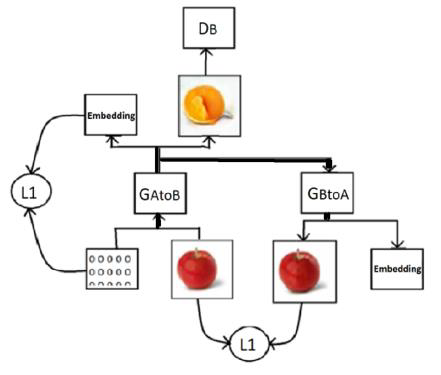
</div>

Настраиваем параметры

In [0]:
n_epochs = 200 # всего эпох
batchSize = 5 # размер батча
dataroot = './{}/'.format(dataset_name) # путь до папки с данными
lr = 0.0002 # learning rate для старта
decay_epoch = 100 # эпоха, начиная с которой leraning rate будет линейно уменьшаться до нуля
size = 256 # размер картинки (подразумевается квадратная)
input_nc = 3 # количество слоёв исходной картинки (без embeddings)
output_nc = 3 # количество слоёв результирующей картинки (без embeddings)
n_cpu = 2 # количество потоков для загрузки картинок

Создаём нейронные сети

In [0]:
netG_A2B = Generator(input_nc + 1, output_nc + 1).to(device)
netG_B2A = Generator(output_nc + 1, input_nc + 1).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

Создаём лоссы, оптимизаторы, картиночные буферы, даталоадер. \
Лоссы: \
1. criterion_GAN - L2 loss - лосс для обучения дискриминатора
2. criterion_cycle - L1 loss - лосс для обучения генератора, оценивает обратное преобразование
3. criterion_identity - L1 loss - лосс для обучения генератора, оценивает преобразование картинки в свой же домен
4. criterion_embeddings - L1 loss - лосс для регуляризации embeddings, используется эффект "Лассо"

Выбрал их такими в результате экспериментов

In [0]:
# Лоссы
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
criterion_embeddings = torch.nn.L1Loss()

# Оптимайзеры и планировщики
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Буфферы
target_real = torch.ones(batchSize, requires_grad=False).to(device)
target_fake = torch.zeros(batchSize, requires_grad=False).to(device)

fake_A_buffer = ImageBuffer(device=device)
fake_B_buffer = ImageBuffer(device=device)

# Даталоадер
transforms_ = [transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = torch.utils.data.DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=batchSize, shuffle=True, num_workers=min(0, n_cpu, batchSize))


Функции для манипуляции с embeddings каналом + функция для выключения подсчёта градиентов дискриминатора

In [0]:
def zero_embeddings(batch):
    return torch.zeros((batch.shape[0], 1, batch.shape[2], batch.shape[3]), device=batch.device)

def cat_embeddings(batch, embeddings):
    return torch.cat((batch, embeddings), dim=1)

def split_embeddings(batch):
    return batch[:,0:-1,:,:], batch[:,-1:,:,:]

def split_only_batch(batch):
    return batch[:,0:-1,:,:]

def requires_grad(nets, value=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        for param in net.parameters():
            param.requires_grad = value

Загружаем модели, в случае дообучения

In [0]:
if os.path.exists('{}/netG_A2B.pth'.format(model_path)):
    netG_A2B.load_state_dict(torch.load('{}/netG_A2B.pth'.format(model_path)))
if os.path.exists('{}/netG_B2A.pth'.format(model_path)):
    netG_B2A.load_state_dict(torch.load('{}/netG_B2A.pth'.format(model_path)))
if os.path.exists('{}/netD_A.pth'.format(model_path)):
    netD_A.load_state_dict(torch.load('{}/netD_A.pth'.format(model_path)))
if os.path.exists('{}/netD_B.pth'.format(model_path)):
    netD_B.load_state_dict(torch.load('{}/netD_B.pth'.format(model_path)))

199/200 epoch. Time for 190/200 batch 1.4459993839263916
loss_G 2.8124871253967285, loss_G_identity 0.23075303435325623:0.2916419208049774
loss_G_GAN 0.6874465942382812:0.2682470381259918
loss_G_cycle 0.6375021934509277:0.6414907574653625, loss_D 0.2328251600265503:0.05978161841630936
loss_embeddings 0.03029143065214157:0.02511448971927166


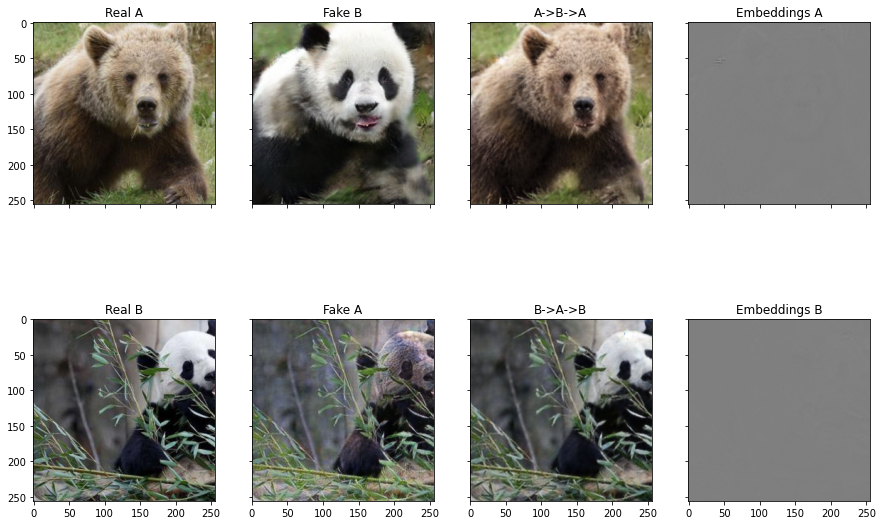

In [18]:
netG_A2B.train()
netG_B2A.train()
netD_A.train()
netD_B.train()

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        tic = time()

        # Начинаем подэпоху
        statistic.startEpoch(epoch + float(i) / len(dataloader))
        
        real_Ai = batch['A'].to(device)
        real_Bi = batch['B'].to(device)
        z_A = zero_embeddings(real_Ai)
        z_B = zero_embeddings(real_Bi)
        real_A = cat_embeddings(real_Ai, z_A)
        real_B = cat_embeddings(real_Bi, z_B)
        
        # Обучаем генератор
        optimizer_G.zero_grad()

        # Identity loss
        same_B = split_only_batch(netG_A2B(real_B))
        loss_identity_B = criterion_identity(same_B, real_Bi)*5.0
        same_A = split_only_batch(netG_B2A(real_A))
        loss_identity_A = criterion_identity(same_A, real_Ai)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        fake_Bi, embeddings_A = split_embeddings(fake_B)
        pred_fake = netD_B(fake_Bi)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        fake_Ai, embeddings_B = split_embeddings(fake_A)
        pred_fake = netD_A(fake_Ai)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = split_only_batch(netG_B2A(fake_B))
        loss_cycle_ABA = criterion_cycle(recovered_A, real_Ai) * 10.0

        recovered_B = split_only_batch(netG_A2B(fake_A))
        loss_cycle_BAB = criterion_cycle(recovered_B, real_Bi) * 10.0
        
        # Embeddings loss (Regularization)
        loss_embeddings_A = criterion_embeddings(z_A, embeddings_A) * 5.0
        loss_embeddings_B = criterion_embeddings(z_B, embeddings_B) * 5.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB + \
                 loss_embeddings_A + loss_embeddings_B

        statistic.identity(loss_identity_A, loss_identity_B)
        statistic.GAN(loss_GAN_A2B, loss_GAN_B2A)
        statistic.cycle(loss_cycle_ABA, loss_cycle_BAB)
        statistic.embeddings(loss_embeddings_A, loss_embeddings_B)
        statistic.G(loss_G)

        # Выключаем подсчёт градиентов для дискриминатора
        requires_grad([netD_A, netD_B], False)
        loss_G.backward()
        
        optimizer_G.step()

        # Очищаем память - выгружаем данные кроме 4-х картинок для отображения
        recovered_A = recovered_A[0].detach()
        recovered_B = recovered_B[0].detach()
        embeddings_A = embeddings_A[0].detach()
        embeddings_B = embeddings_B[0].detach()

        # Включаем подсчёт градиентов для дискриминатора
        requires_grad([netD_A, netD_B], True)

        # Обучаем дискриминатор A
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_Ai)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_Ai2 = fake_A_buffer.push_and_pop(fake_Ai)
        pred_fake = netD_A(fake_Ai2.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()

        # Обучаем дискриминатор B
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_Bi)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_Bi2 = fake_B_buffer.push_and_pop(fake_Bi)
        pred_fake = netD_B(fake_Bi2.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()

        statistic.D(loss_D_A, loss_D_B)

        # Очищаем память - выгружаем данные кроме 4-х картинок для отображения
        real_Ai = real_Ai[0].detach()
        real_Bi = real_Bi[0].detach()
        fake_Ai = fake_Ai[0].detach()
        fake_Bi = fake_Bi[0].detach()

        toc = time()
        
        if i % 10 == 0:
            # Отображаем картинки и лоссы на каждой 10-ой эпохе (чтобы успеть рассмотреть)

            clear_output(wait=True)
            print('{}/{} epoch. Time for {}/{} batch {}'.format(epoch, n_epochs, i, len(dataloader), toc - tic))

            statistic.print()
            
            grid_show([(real_Ai, 'Real A'), (fake_Bi, 'Fake B'), (recovered_A, 'A->B->A'), (embeddings_A, 'Embeddings A'),
                       (real_Bi, 'Real B'), (fake_Ai, 'Fake A'), (recovered_B, 'B->A->B'), (embeddings_B, 'Embeddings B')])
            plt.show()

    # Пересчитывам leraning rate
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Сохраняем модели и статистику
    torch.save(netG_A2B.state_dict(), '{}/netG_A2B.pth'.format(model_path))
    torch.save(netG_B2A.state_dict(), '{}/netG_B2A.pth'.format(model_path))
    torch.save(netD_A.state_dict(), '{}/netD_A.pth'.format(model_path))
    torch.save(netD_B.state_dict(), '{}/netD_B.pth'.format(model_path))
    torch.save(epoch, '{}/n_epoch.pth'.format(model_path))
    torch.save(statistic, '{}/statistic.pth'.format(model_path))

In [19]:
!nvidia-smi

Sun Jun 14 17:05:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    38W / 250W |  15267MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
statistic.fix()

Посмотрим на тестовые данные

In [0]:
transforms_val = [transforms.Resize(size), 
               transforms.ToTensor(),
               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader_val = torch.utils.data.DataLoader(ImageDataset(dataroot, transforms_=transforms_val, unaligned=True), 
                        batch_size=batchSize, shuffle=False)

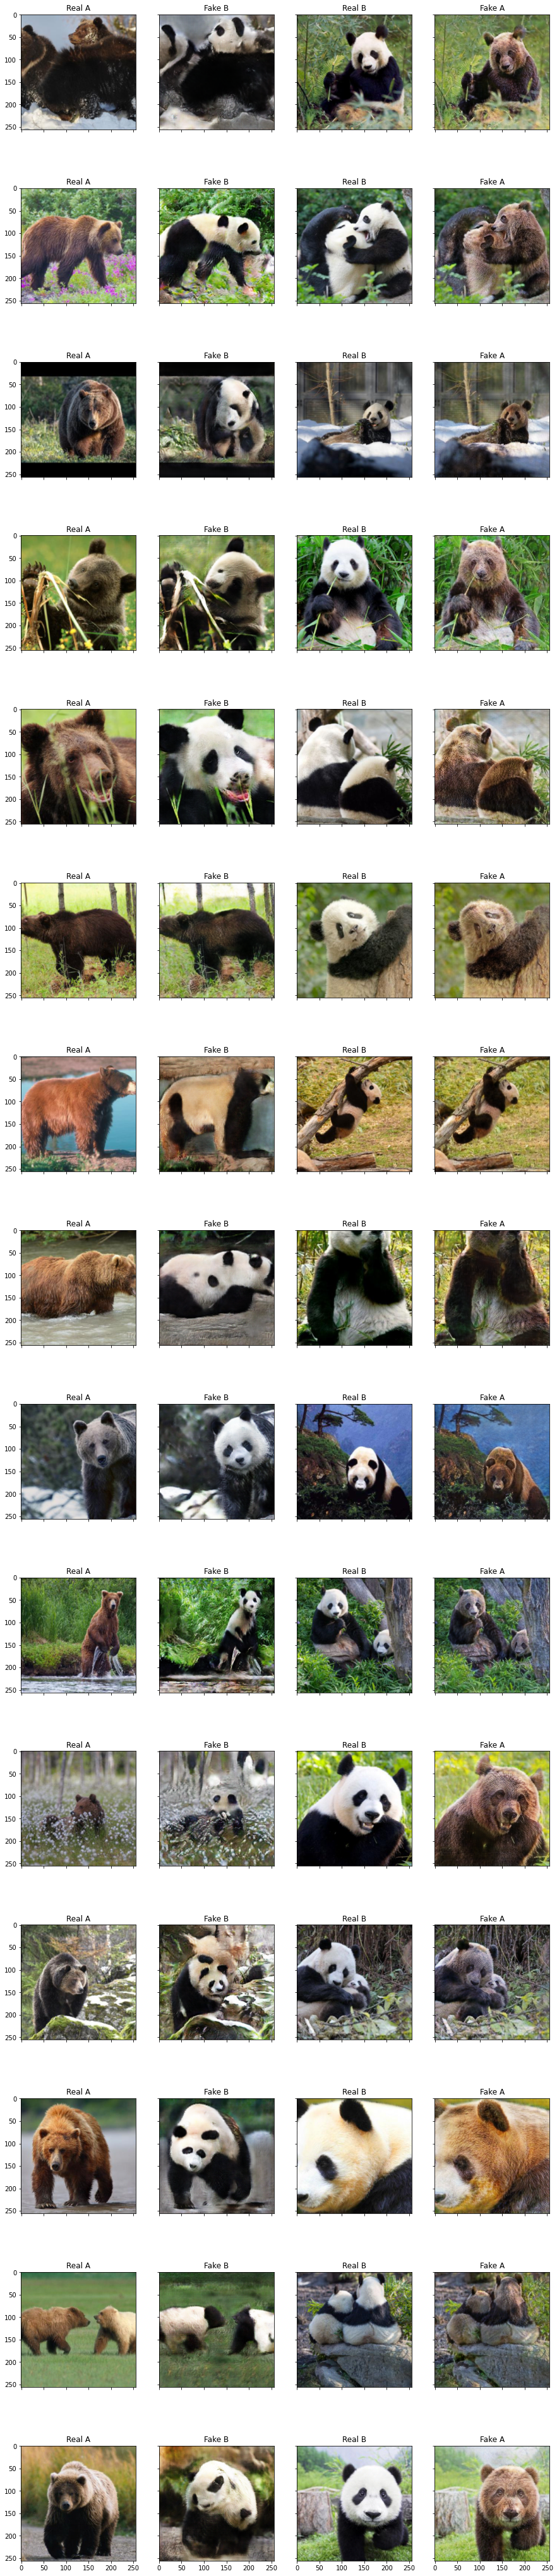

In [26]:
netG_A2B.eval()
netG_B2A.eval()
netD_A.eval()
netD_B.eval()

images = []

for batch in dataloader_val:
    real_Ai = batch['A'].to(device)
    real_Bi = batch['B'].to(device)

    with torch.no_grad():
        fake_Bi = split_only_batch(netG_A2B(cat_embeddings(real_Ai, zero_embeddings(real_Ai)))).cpu()
        fake_Ai = split_only_batch(netG_B2A(cat_embeddings(real_Bi, zero_embeddings(real_Bi)))).cpu()

    real_Ai = real_Ai.cpu()
    real_Bi = real_Bi.cpu()

    for real_A, fake_B, real_B, fake_A in zip(real_Ai, fake_Bi, real_Bi, fake_Ai):
        images.append((real_A, "Real A"))
        images.append((fake_B, "Fake B"))
        images.append((real_B, "Real B"))
        images.append((fake_A, "Fake A"))

    if len(images) > 15 * 4: break # 15 строчек

grid_show(images, max_images=15 * 4, cols=4)
plt.show()

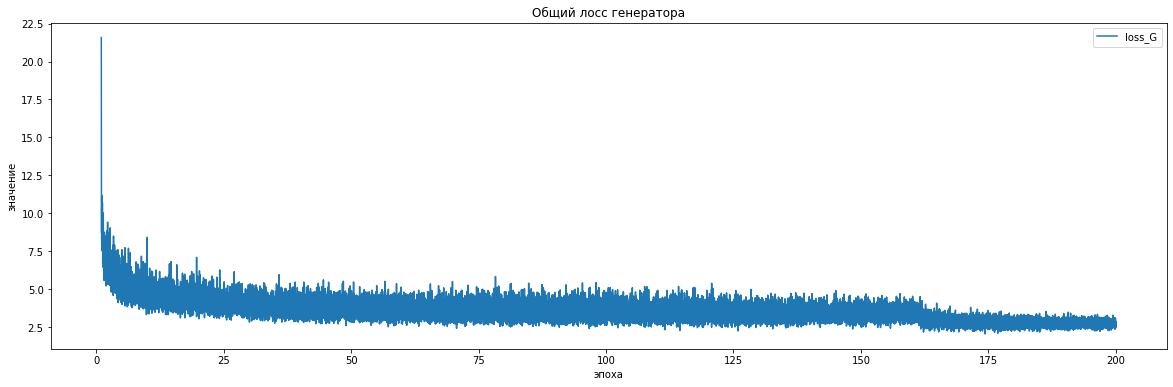

In [27]:
plt.figure(figsize=(20, 6))
plt.title('Общий лосс генератора')
plt.xlabel('эпоха')
plt.ylabel('значение')
plt.plot(statistic.epoch, statistic.loss_G, label='loss_G')
plt.legend()
plt.show();

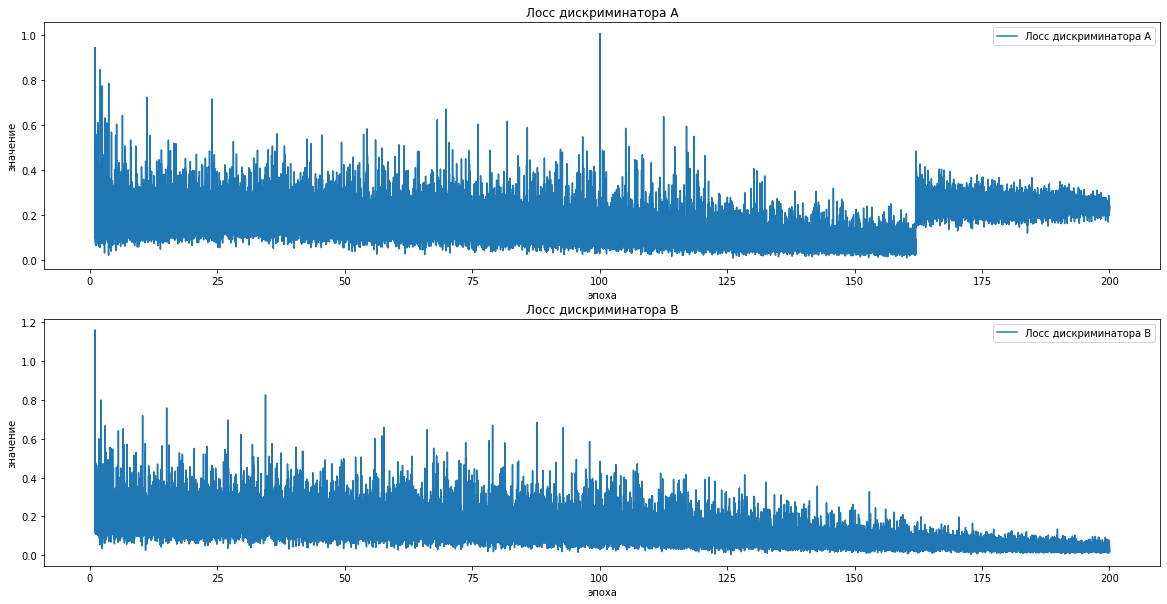

In [34]:
plt.figure(figsize=(20, 10))
for i, (loss, name) in enumerate(zip([statistic.loss_D_A, statistic.loss_D_B], ['Лосс дискриминатора A', 'Лосс дискриминатора B'])):
    plt.subplot(2, 1, i + 1)
    plt.title(name)
    plt.xlabel('эпоха')
    plt.ylabel('значение')
    plt.plot(statistic.epoch, loss, label=name)
    plt.legend()
plt.show();

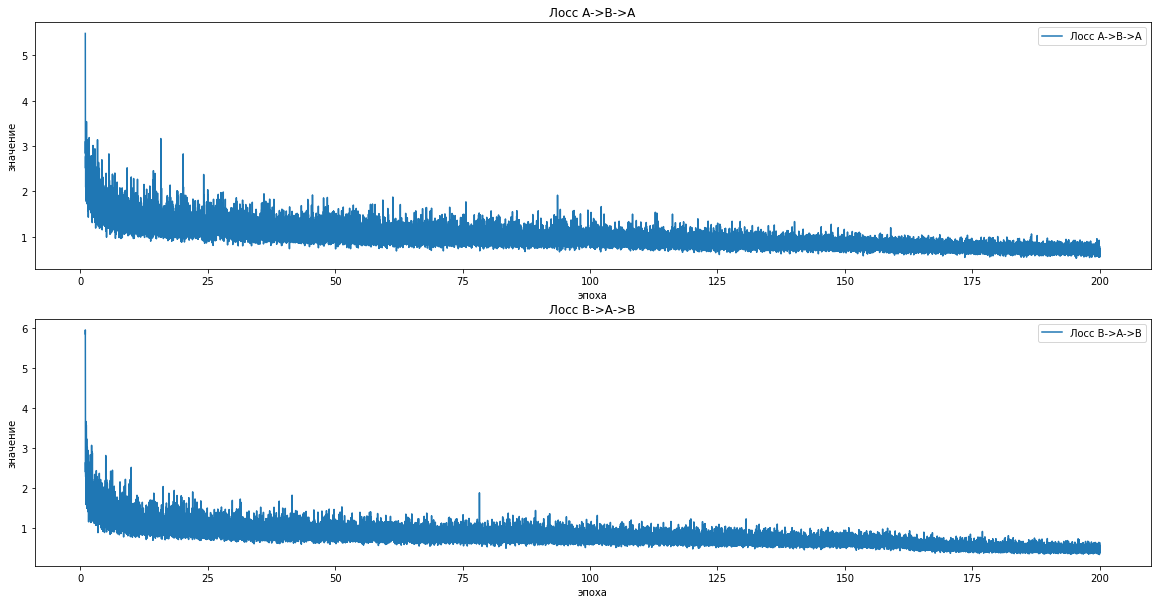

In [35]:
plt.figure(figsize=(20, 10))
for i, (loss, name) in enumerate(zip([statistic.loss_cycle_ABA, statistic.loss_cycle_BAB], ['Лосс A->B->A', 'Лосс B->A->B'])):
    plt.subplot(2, 1, i + 1)
    plt.title(name)
    plt.xlabel('эпоха')
    plt.ylabel('значение')
    plt.plot(statistic.epoch, loss, label=name)
    plt.legend()
plt.show();

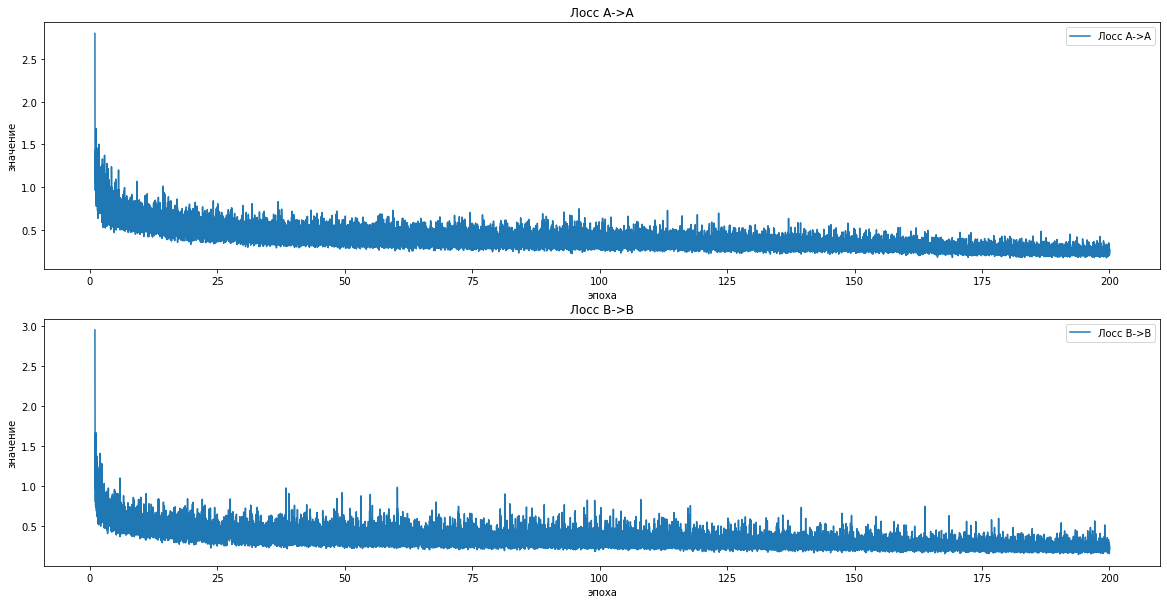

In [37]:
plt.figure(figsize=(20, 10))
for i, (loss, name) in enumerate(zip([statistic.loss_identity_A, statistic.loss_identity_B], ['Лосс A->A', 'Лосс B->B'])):
    plt.subplot(2, 1, i + 1)
    plt.title(name)
    plt.xlabel('эпоха')
    plt.ylabel('значение')
    plt.plot(statistic.epoch, loss, label=name)
    plt.legend()
plt.show();

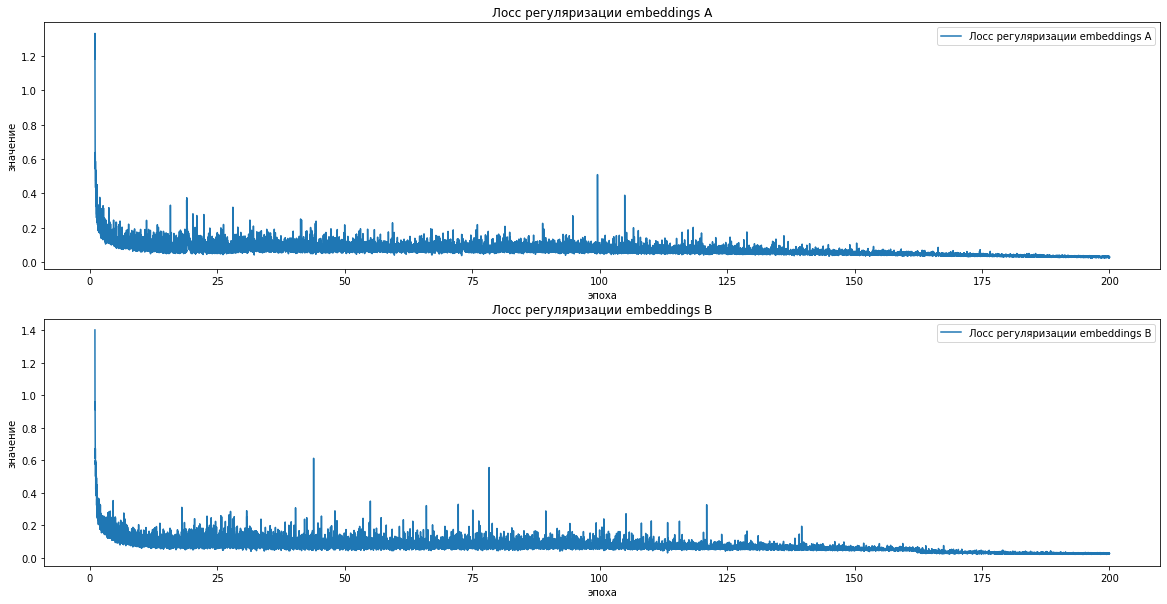

In [38]:
plt.figure(figsize=(20, 10))
for i, (loss, name) in enumerate(zip([statistic.loss_embeddings_A, statistic.loss_embeddings_B], ['Лосс регуляризации embeddings A', 'Лосс регуляризации embeddings B'])):
    plt.subplot(2, 1, i + 1)
    plt.title(name)
    plt.xlabel('эпоха')
    plt.ylabel('значение')
    plt.plot(statistic.epoch, loss, label=name)
    plt.legend()
plt.show();